Импорт библиотек
--------------------

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold

In [3]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

In [5]:
from sklearn.preprocessing import LabelEncoder

In [6]:
import warnings
warnings.filterwarnings('ignore')

EDA
--------------------

In [7]:
DTYPE = {
    "id":np.int64,
    "CustomerId":np.int64,
    "CreditScore":np.int64,
    "Tenure":np.int8,
    "Balance":np.float64,
    "NumOfProducts":np.int8,
    "HasCrCard":np.int8,
    "IsActiveMember":np.int8,
    "EstimatedSalary":np.float64,
}

def dataloader(path: str) -> pd.DataFrame:
    """takes in a test/train data path and returns a processed dataframe"""
    df = pd.read_csv(path)
    df = (df
          .astype(DTYPE)
          # one-hot-encoding gender
          .replace({"Gender":{"Male":0, "Female":1}})
          .astype({"Gender":np.int8})
          # round age and convert to int
          .assign(age=lambda d: d['Age'].round(0).astype(int))
         )
    return df

In [8]:
## reload data
df = dataloader('train.csv')

In [9]:
from ydata_profiling import ProfileReport


In [10]:
# Генерация профильного отчета
profile = ProfileReport(
        df, title="Profile Report of the UCI Bank Marketing Dataset", explorative=True
    )

In [11]:
#profile

In [12]:
def add_new_features(df):
    b = [0,30,40,50,65,100]
    l = ['<30', '30-40', '40-50','50-65','65+']
    df['AgeGroup'] = pd.cut(df['Age'], bins=b, labels=l, include_lowest=True)
    df['Balance_to_Salary_Ratio'] = df['Balance'] / df['EstimatedSalary']
    df['CreditScoreTier'] = pd.cut(df['CreditScore'], bins=[0, 650, 750, 850], labels=['0', '1', '2'])
    df['IsActive_by_CreditCard'] = df['HasCrCard'] * df['IsActiveMember']
    df['Customer_Status'] = df['Tenure'].apply(lambda x:0 if x < 2 else 1)
    return df

In [13]:
df=add_new_features(df)

In [14]:
def kill_upon_alerts(df):
    df_clean = df.drop(['age', 'Tenure', 'id', 'Balance', 'Surname', 'CustomerId', 'Age' ], axis=1)
    return df_clean

In [15]:
df=kill_upon_alerts(df)

In [17]:
df.isna().sum().sum()

0

In [18]:
df.dtypes

CreditScore                   int64
Geography                    object
Gender                         int8
NumOfProducts                  int8
HasCrCard                      int8
IsActiveMember                 int8
EstimatedSalary             float64
Exited                        int64
AgeGroup                   category
Balance_to_Salary_Ratio     float64
CreditScoreTier            category
IsActive_by_CreditCard         int8
Customer_Status               int64
dtype: object

In [19]:
df.columns = df.columns.str.lower()

In [20]:
df.geography = df.geography.str.lower()

Preprocessing
--------------------

In [21]:
X,y = df.drop('exited', axis=1), df.exited

In [22]:
objects = ['object','category', 'bool']
cat_features = X.select_dtypes(include=objects).columns.tolist()

numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_features = X.select_dtypes(include=numerics).columns.tolist()

print(f'numeric={num_features}\ncats={cat_features}')

numeric=['creditscore', 'gender', 'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary', 'balance_to_salary_ratio', 'isactive_by_creditcard', 'customer_status']
cats=['geography', 'agegroup', 'creditscoretier']


In [23]:
num_pipeline = Pipeline(steps=[
    ('std_scaler', StandardScaler()),
])
cat_pipeline = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown='ignore'))
])

In [24]:
preprocessor = ColumnTransformer(transformers=[
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])

In [25]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

In [75]:
stat = pd.DataFrame(columns=['params', 'cv_ROC_AUC_score', 'cv_std'])

In [72]:

rf_tuned_1 = {'max_depth': 10, 'max_features': 9, 'n_estimators': 200}
rf_tuned_2 = {'criterion': 'log_loss',
 'max_depth': 11,
 'max_features': 11,
 'min_samples_leaf': 4,
 'min_samples_split': 12,
 'n_estimators': 100}
rf_tuned_3 = {'max_depth': 8, 'max_features': 23, 'n_estimators': 220, 'min_samples_split': 12, 'min_samples_leaf': 18, 'criterion': 'gini'}

In [73]:
basic_model = RandomForestClassifier(random_state=42)
hyperopt = RandomForestClassifier(random_state=42, **rf_tuned_1)
hyperopt_6_params = RandomForestClassifier(random_state=42, **rf_tuned_2)
optuna_6_params = RandomForestClassifier(random_state=42, **rf_tuned_3)
mods = [basic_model, hyperopt, hyperopt_6_params, optuna_6_params]
mod_types = ['basic_model', 'hyperopt_3_params', 'hyperopt_6_params', 'optuna_6_params']

In [76]:
for i in range(len(mods)):
    model = Pipeline(steps=[("preprocessor",preprocessor),
                            ("classifier", mods[i])
                        ])
    model.fit(Xtrain, ytrain)

    cv = StratifiedKFold(n_splits=5)
    scores = cross_val_score(model, Xtrain, ytrain, cv=cv, scoring = 'roc_auc')

    res = pd.DataFrame({
        'params': [mod_types[i]],
        'cv_ROC_AUC_score': [np.mean(scores)],
        'cv_std': [np.std(scores)]})
    stat = pd.concat([stat, res]).reset_index(drop=True)

In [77]:
stat 

,params,cv_ROC_AUC_score,cv_std
0,basic_model,0.852160,0.002840
1,hyperopt_3_params,0.882080,0.002012
2,hyperopt_6_params,0.881265,0.002015
3,optuna_6_params,0.881719,0.002179


Hyperopt implementation
----------------

In [47]:
from hyperopt import fmin, tpe, hp, Trials, space_eval

param_vars = {
  'max_depth': hp.choice('max_depth', list(range(5, 50))),  
  'max_features': hp.choice('max_features', list(range(3, 50))),
  'n_estimators': hp.choice('n_estimators', list(range(10, 300, 10))),
  'min_samples_split': hp.choice('min_samples_split', list(range(2, 17, 2))),
  'min_samples_leaf': hp.choice('min_samples_leaf', list(range(1, 20, 1))),
  'criterion': hp.choice('criterion', ['gini', 'log_loss']),
}

def obj_fnc(params):
  model = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(**params,
                                              random_state=42))
    ])

  model.fit(Xtrain, ytrain)
  preds = model.predict_proba(Xtest)

  return -1*roc_auc_score(ytest,preds[:,1])

trials = Trials()
best_params = fmin(obj_fnc, space=param_vars, algo=tpe.suggest, max_evals=40,
                   trials=trials, show_progressbar=True)

100%|██████████| 40/40 [54:22<00:00, 81.57s/trial, best loss: -0.8831700697482433]  


In [52]:
trials.best_trial

{'state': 2,
 'tid': 8,
 'spec': None,
 'result': {'loss': -0.8831700697482433, 'status': 'ok'},
 'misc': {'tid': 8,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'criterion': [8],
   'max_depth': [8],
   'max_features': [8],
   'min_samples_leaf': [8],
   'min_samples_split': [8],
   'n_estimators': [8]},
  'vals': {'criterion': [1],
   'max_depth': [6],
   'max_features': [8],
   'min_samples_leaf': [3],
   'min_samples_split': [5],
   'n_estimators': [9]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2024, 7, 28, 12, 25, 47, 169000),
 'refresh_time': datetime.datetime(2024, 7, 28, 12, 26, 17, 67000)}

In [53]:
space_eval(param_vars, trials.argmin)

{'criterion': 'log_loss',
 'max_depth': 11,
 'max_features': 11,
 'min_samples_leaf': 4,
 'min_samples_split': 12,
 'n_estimators': 100}

{'max_depth': 10, 'max_features': 9, 'n_estimators': 200}

Optuna implementation
----------------

In [44]:
import optuna

In [55]:
def obj_optuna(trial):
    
    params = {
        'max_depth': trial.suggest_int('max_depth', 5, 50),  
        'max_features': trial.suggest_int('max_features', 3, 50),
        'n_estimators': trial.suggest_int('n_estimators', 10, 300, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 17, 2),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20, 1),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'log_loss'])
    }
    
    model = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(**params,
                                              random_state=42))])
    model.fit(Xtrain, ytrain)
    preds = model.predict_proba(Xtest)

    return roc_auc_score(ytest,preds[:,1])

study_optuna = optuna.create_study(direction='maximize', pruner='MedianPruner')
study_optuna.optimize(obj_optuna, n_trials=40)
print('Best one:', study_optuna.best_trial.params, study_optuna.best_value)

[I 2024-07-28 17:01:05,924] A new study created in memory with name: no-name-f573fb8c-920d-42fd-a02a-4e2c648d7678
[I 2024-07-28 17:03:09,574] Trial 0 finished with value: 0.872968863467557 and parameters: {'max_depth': 21, 'max_features': 20, 'n_estimators': 120, 'min_samples_split': 10, 'min_samples_leaf': 5, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.872968863467557.
[I 2024-07-28 17:03:52,227] Trial 1 finished with value: 0.8730782034890567 and parameters: {'max_depth': 38, 'max_features': 8, 'n_estimators': 140, 'min_samples_split': 8, 'min_samples_leaf': 4, 'criterion': 'log_loss'}. Best is trial 1 with value: 0.8730782034890567.
[I 2024-07-28 17:05:02,267] Trial 2 finished with value: 0.8820291149162164 and parameters: {'max_depth': 12, 'max_features': 37, 'n_estimators': 160, 'min_samples_split': 8, 'min_samples_leaf': 11, 'criterion': 'gini'}. Best is trial 2 with value: 0.8820291149162164.
[I 2024-07-28 17:05:24,287] Trial 3 finished with value: 0.8766058492979202

Best one: {'max_depth': 8, 'max_features': 23, 'n_estimators': 220, 'min_samples_split': 12, 'min_samples_leaf': 18, 'criterion': 'gini'} 0.8831613993712514


Выводы
----------------

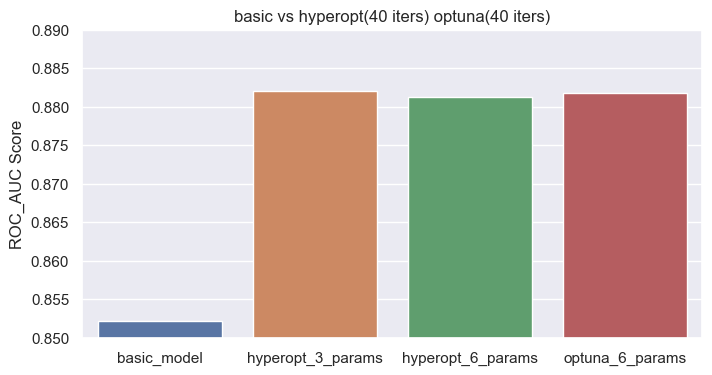

In [83]:
%matplotlib inline
sns.set(rc={'figure.figsize':(8, 4)})
sns.barplot(x='params', y='cv_ROC_AUC_score', data=stat, palette='deep')
plt.title('basic vs hyperopt(40 iters) optuna(40 iters)')
plt.ylim([0.85, 0.89])
plt.ylabel('ROC_AUC Score')
plt.xlabel('')
plt.show()

Да, гиперопт работает, но, по-ощущениям, Optuna лучше.                   
1. У оптюны более логичный синтаксис (в гиперопте все от минимизации функции потерь).
2. В гиперопте нет опции продолжения исследования (типа optimize optuna).
3. Судя по документации, гиперопт не умеет прунить неудачные попытки, однако существенных отличий в быстродействии я не увидел. 
Возможно, оно будет более заметно при увеличении числа трейлов.
4. *Увеличение числа перебираемых гиперпараметров не дало вау-эффекта в рамках 40 трейлов. Можно было бы покрутить еще пару сотен трейлов, но задание не про максимальный скор, да и, вероятно, удалить больше времени обработке датасета и фича инжинирингу было бы полезнее для итогового скора.

----